# Implementation of Disaster tweet detection

## Loading Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import emoji

from IPython.display import Markdown as md
plt.style.use('ggplot')

In [4]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

## Loading data

In [6]:
train_path = "input/train.csv"
test_path = "input/test.csv"

In [7]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [8]:
df_train = df_train[['text','target']]
df_test = df_test[['text']]

## Cleaning text

In [12]:
# Removing URLs
def urls(sent):
    return re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',sent)
def url_counts(sent):
    return len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',sent))
def remove_urls(sent):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',sent)

In [13]:
# Remove emojis and convert emoji to text.

def emoji_extraction(sent):
    e_sent = emoji.demojize(sent)
    
    return re.findall(':(.*?):',e_sent)
def emoji_count(sent):
    e_sent = emoji.demojize(sent)
    return len(re.findall(':(.*?):',e_sent))

def emoji_to_text(sent):
    e_sent = emoji.demojize(sent)
    emo = re.findall(':(.*?):',e_sent)
    for e in emo:
        e_sent = e_sent.replace(':{}:'.format(e),'{}'.format(e))
    return e_sent

In [14]:
# Remove hashtags in tweets
def find_hashtags(text):
    gethashtags = re.findall('#\w*[a-zA-Z]\w*',text)
    return gethashtags

def count_hashtags(text):
    gethashtags = re.findall('#\w*[a-zA-Z]\w*',text)
    return len(gethashtags)

def remove_hashtags(text):
    return re.sub('#\w*[a-zA-Z]\w*','',text)

In [15]:
# Remove @Username in tweets
def extract_username(sent):
    usernames = re.findall('@[A-Za-z0-9_$]*',sent)
    return usernames

def count_username(sent):
    return len(re.findall('@[A-Za-z0-9_$]*',sent))

def replace_username(sent):
    usernames = extract_username(sent)
    for un in usernames:
        un = re.sub('@','',un)
        sent = sent.replace('@{}'.format(un),'{}'.format(un))
    return sent

In [16]:
# Removing phone numbers
def find_number(text):
    getnumber = re.findall('#[0-9]+',text)
    return getnumber

def count_number(text):
    getnumber = re.findall('#[0-9]+',text)
    return len(getnumber)

def remove_number(text):
    return re.sub('#[0-9]+','',text)

In [17]:
# Removing punctuations
def find_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?',text)
    return getpunctuation

def count_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?',text)
    return len(getpunctuation)

def remove_punctuations(text):
    return re.sub('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?','',text)

In [18]:
# Removing other symbols
def remove_symbols(text):
    return re.sub('[~:*ÛÓ_å¨È$#&%^ª|+-]+?','',text)

In [19]:
# Correct spellings
from spellchecker import SpellChecker
from textblob import TextBlob

def find_typo(sent):
    spell = SpellChecker()
    words = sent.split()
    words = spell.unknown(words)
    print(words)
    return words

def count_typo(sent):
    return find_typo(sent), len(find_typo(sent))

def correct_typo(sent):
    spell = SpellChecker()
    words = sent.split()
    words = spell.unknown(words)
    find = []
    for word in words:
        find.append(spell.correction(word))
    return find    

def correct_byspellchecker(sent):
    ic, c = list(find_typo(sent)), list(correct_typo(sent))
    for i in range(len(ic)):
        sent = sent.replace(ic[i],c[i])
    return sent

def correct_bytextblob(sent):
    return str(TextBlob(sent).correct())

## Training the model on no pre-processing

In [25]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(df_train,test_size = 0.2,random_state=0,stratify = df_train.target.values)

print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (6090, 2)
valid shape :  (1523, 2)


In [23]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

In [26]:
X_train = vectorizer.fit_transform(train.text.values)
X_valid = vectorizer.transform(valid.text.values)

y_train = train.target.values
y_valid = valid.target.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (6090, 18394)
X_train.shape :  (1523, 18394)
y_train.shape :  (6090,)
y_valid.shape :  (1523,)


In [27]:
from sklearn.naive_bayes import MultinomialNB

baseline_clf = MultinomialNB()
baseline_clf.fit(X_train,y_train)

MultinomialNB()

In [28]:
baseline_prediction = baseline_clf.predict(X_valid)
baseline_accuracy = accuracy_score(y_valid,baseline_prediction)
print("training accuracy Score    : ",baseline_clf.score(X_train,y_train))
print("Validdation accuracy Score : ",baseline_accuracy )

training accuracy Score    :  0.9262725779967159
Validdation accuracy Score :  0.799080761654629


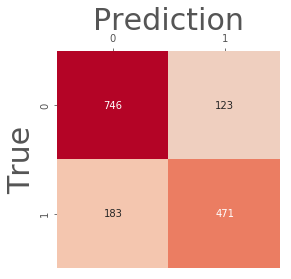

In [29]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,baseline_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

## Training the model with preprocessing (except spelling corrector)

In [33]:
def preprocessing(df):
    df['Char_length']       = df['text'].apply(len)
#     df['word_count']        = df.text.apply(word_count)
#     df['url_count']         = df.text.apply(url_counts)
#     df['urls']              = df.text.apply(urls)
    df['text']              = df.text.apply(remove_urls)
#     df['emoji_count']       = df.text.apply(emoji_count)
#     df['emojis']            = df.text.apply(emoji_extraction)
    df['text']              = df['text'].apply(emoji_to_text)
#     df['hash_count']        = df.text.apply(count_hashtags)
#     df['hashtags']          = df.text.apply(find_hashtags)
    df['text']              = df.text.apply(remove_hashtags)
    df['text']              = df.text.apply(replace_username)
#     df['count_number']      = df.text.apply(count_number)
#     df['number']            = df.text.apply(find_number)
    df['text']              = df.text.apply(remove_number)
#     df['count_punctuation'] = df.text.apply(count_punctuations)
#     df['punctuation']       = df.text.apply(find_punctuations)
    df['text']              = df.text.apply(remove_punctuations)
    df['text']              = df.text.apply(remove_symbols)
                                            
    return df

In [36]:
%%time

df_train = preprocessing(df_train)

CPU times: user 3.72 s, sys: 37.1 ms, total: 3.76 s
Wall time: 4.01 s


In [37]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(df_train,test_size = 0.2,random_state=0,stratify = df_train.target.values)

print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (6090, 3)
valid shape :  (1523, 3)


In [38]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

In [40]:
X_train = vectorizer.fit_transform(train.text.values)
X_valid = vectorizer.transform(valid.text.values)

y_train = train.target.values
y_valid = valid.target.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (6090, 14275)
X_train.shape :  (1523, 14275)
y_train.shape :  (6090,)
y_valid.shape :  (1523,)


In [41]:
from sklearn.naive_bayes import MultinomialNB

baseline_clf = MultinomialNB()
baseline_clf.fit(X_train,y_train)

MultinomialNB()

In [42]:
baseline_prediction = baseline_clf.predict(X_valid)
baseline_accuracy = accuracy_score(y_valid,baseline_prediction)
print("training accuracy Score    : ",baseline_clf.score(X_train,y_train))
print("Validdation accuracy Score : ",baseline_accuracy )

training accuracy Score    :  0.9177339901477832
Validdation accuracy Score :  0.8017071569271176


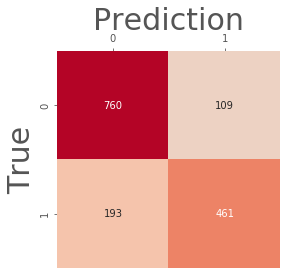

In [43]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,baseline_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

## Out of Dictionary analysis

In [45]:
word_dict = []
embeddings_index = {}
f = open('glove.twitter.27B.25d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [49]:
def check_embeddings(sent, embeddings):
    unk = set()
    words = sent.split()
    for word in words:
        word = word.lower()
        if word not in embeddings:
            unk.add(word)
    return unk, len(unk)

In [50]:
misspelled_e = 0
set_words_e = set()
for text in df_train['text']:
    words, count_ = check_embeddings(text, embeddings_index)
    set_words_e = set_words_e.union(words)
    misspelled_e += count_

In [51]:
set_words_

{'legwalked',
 'rachelrofe',
 'demolitiond',
 'jeepêsunk',
 'cstsmith',
 'weiqin',
 'msoreo',
 'rdconsider',
 'urgentthere',
 'mauds99',
 '1russian',
 'lordrsbiscuits',
 '÷british',
 'eudrylantiqua',
 'officialrealrap',
 'elielcruz',
 'tsunaminopeach',
 'kendraleigh13',
 '113',
 'comeeeee',
 '375000',
 'thenissonian',
 'aphl',
 'thetimepast',
 'rjg0789',
 '60mph',
 '230',
 'barthubbuch',
 'wrightsboro',
 'queenwendy',
 'thatfatguy',
 'vvorm',
 'duststormfilm',
 'kasad1lla',
 'ashrafiyah',
 'hashtagteaclub',
 'caitsroberts',
 'ïlordbrathwaite',
 'on¡¡',
 'ladins',
 'satoshis',
 'cainsuch',
 'colomr',
 'uruan',
 'wonderousallure',
 'phdsquares',
 'lopezandthelion',
 'senschumer',
 'johnfugelsang',
 'withdrawur',
 'blazingelwoods',
 '24v',
 'homeworldgym',
 '217',
 'alllll',
 '97',
 'avysss',
 'crossborder',
 'lasiren',
 'paleface',
 'nockthie',
 'tinderbox',
 'zrnf',
 '8615',
 '295ss100',
 'blanktgt',
 'rconspiracy',
 'dlin71',
 'titadom',
 'thedailybeast',
 'alhanda',
 'aredeluged',
 'h

In [81]:
import wordninja

In [86]:
no_of_corrected = 0
corrected_words = {}
for word in set_words_e:
    split_words = wordninja.split(word)
    valid = True
    if split_words == []:
        pass
    for w in split_words:
        if w not in embeddings_index:
            valid = False
            break
            
    if valid:
        corrected_words[word] = split_words

In [87]:
corrected_words

{'legwalked': ['leg', 'walked'],
 'rachelrofe': ['rachel', 'r', 'of', 'e'],
 'demolitiond': ['demolition', 'd'],
 'jeepêsunk': ['jeep', 'sunk'],
 'cstsmith': ['cst', 'smith'],
 'weiqin': ['wei', 'qin'],
 'msoreo': ['ms', 'oreo'],
 'rdconsider': ['rd', 'consider'],
 'urgentthere': ['urgent', 'there'],
 'lordrsbiscuits': ['lord', 'rs', 'biscuits'],
 '÷british': ['british'],
 'eudrylantiqua': ['eu', 'dry', 'l', 'anti', 'qua'],
 'officialrealrap': ['official', 'real', 'rap'],
 'elielcruz': ['eli', 'el', 'cruz'],
 'tsunaminopeach': ['tsunami', 'no', 'peach'],
 'comeeeee': ['come', 'eeee'],
 'thenissonian': ['then', 'is', 'son', 'ian'],
 'aphl': ['a', 'ph', 'l'],
 'thetimepast': ['the', 'time', 'past'],
 'barthubbuch': ['bart', 'hub', 'buch'],
 'wrightsboro': ['wrights', 'boro'],
 'queenwendy': ['queen', 'wendy'],
 'thatfatguy': ['that', 'fat', 'guy'],
 'vvorm': ['v', 'vor', 'm'],
 'duststormfilm': ['dust', 'storm', 'film'],
 'ashrafiyah': ['ashraf', 'i', 'yah'],
 'hashtagteaclub': ['hash', 

In [92]:
def replace_unknown_with_known(sent):
    to_replace = {}
    words = sent.split()
    for word in words:
        if word not in embeddings_index:
            split_words = wordninja.split(word)
            new_word = ' '.join(split_words)
            to_replace[word] = new_word
    for word in to_replace:
        sent = sent.replace(word, to_replace[word])
    return sent

In [93]:
new_df = df_train.copy()

In [95]:
new_df['text'] = new_df['text'].apply(replace_unknown_with_known)

In [96]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = df_train.target.values)

print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (6090, 3)
valid shape :  (1523, 3)


In [97]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))

In [98]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

In [99]:
X_train = vectorizer.fit_transform(train.text.values)
X_valid = vectorizer.transform(valid.text.values)

y_train = train.target.values
y_valid = valid.target.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (6090, 12822)
X_train.shape :  (1523, 12822)
y_train.shape :  (6090,)
y_valid.shape :  (1523,)


In [100]:
from sklearn.naive_bayes import MultinomialNB

baseline_clf = MultinomialNB()
baseline_clf.fit(X_train,y_train)

MultinomialNB()

In [101]:
baseline_prediction = baseline_clf.predict(X_valid)
baseline_accuracy = accuracy_score(y_valid,baseline_prediction)
print("training accuracy Score    : ",baseline_clf.score(X_train,y_train))
print("Validdation accuracy Score : ",baseline_accuracy )

training accuracy Score    :  0.909688013136289
Validdation accuracy Score :  0.7957977675640184


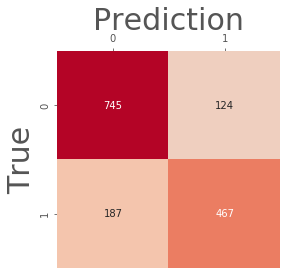

In [102]:
plt.figure(figsize = (4,4))
class_label = [0,1]
fig = sns.heatmap(confusion_matrix(y_valid,baseline_prediction),cmap= "coolwarm",annot=True,vmin=0,cbar = False,
            center = True,xticklabels=class_label,yticklabels=class_label, fmt='d' )
fig.set_xlabel("Prediction",fontsize=30)
fig.xaxis.set_label_position('top')
fig.set_ylabel("True",fontsize=30)
fig.xaxis.tick_top()

In [103]:
misspelled_e = 0
set_words_e = set()
for text in new_df['text']:
    words, count_ = check_embeddings(text, embeddings_index)
    set_words_e = set_words_e.union(words)
    misspelled_e += count_

In [104]:
len(set_words_e)

809